<a href="https://colab.research.google.com/github/maximum4645/Garbage_Classification/blob/main/exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os
import shutil
import torch
import torchvision.transforms as transforms
import torchvision
import torchvision.models as models
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision.transforms.functional import adjust_sharpness
import matplotlib.pyplot as plt
import numpy as np

# Data

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
# Download and extract the dataset
dataset_zip = 'garbage-classification.zip'
base_dir = './Garbage_Classification'
data_dir = os.path.join(base_dir, 'Garbage classification/Garbage classification')

if not os.path.exists(data_dir):
    print("Downloading Garbage Classification dataset...")
    !kaggle datasets download -d asdasdasasdas/garbage-classification -p .
    print("Extracting dataset...")
    !unzip -q garbage-classification.zip -d {base_dir}
    os.remove(dataset_zip)
    print("Download and extraction complete!")
else:
    print("Dataset already exists. Skipping download.")

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
100% 82.0M/82.0M [00:04<00:00, 24.4MB/s]
100% 82.0M/82.0M [00:04<00:00, 18.6MB/s]
Extracting dataset...
Download and extraction complete!


In [11]:
# Define transformations for normalization and data augmentation
train_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Lambda(lambda img: adjust_sharpness(img, sharpness_factor=2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Lambda(lambda img: adjust_sharpness(img, sharpness_factor=2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset using ImageFolder
dataset = ImageFolder(root=data_dir)

# Split into training and testing datasets
train_idx, test_idx = train_test_split(
    list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets
)

train_set = torch.utils.data.Subset(dataset, train_idx)
test_set = torch.utils.data.Subset(dataset, test_idx)

# Apply transformations
train_set.dataset.transform = train_transform
test_set.dataset.transform = test_transform

# DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Print class names and dataset sizes
classes = dataset.classes
print("Classes:", classes)
print(f"Train dataset size: {len(train_set)}")
print(f"Test dataset size: {len(test_set)}")


Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Train dataset size: 2021
Test dataset size: 506


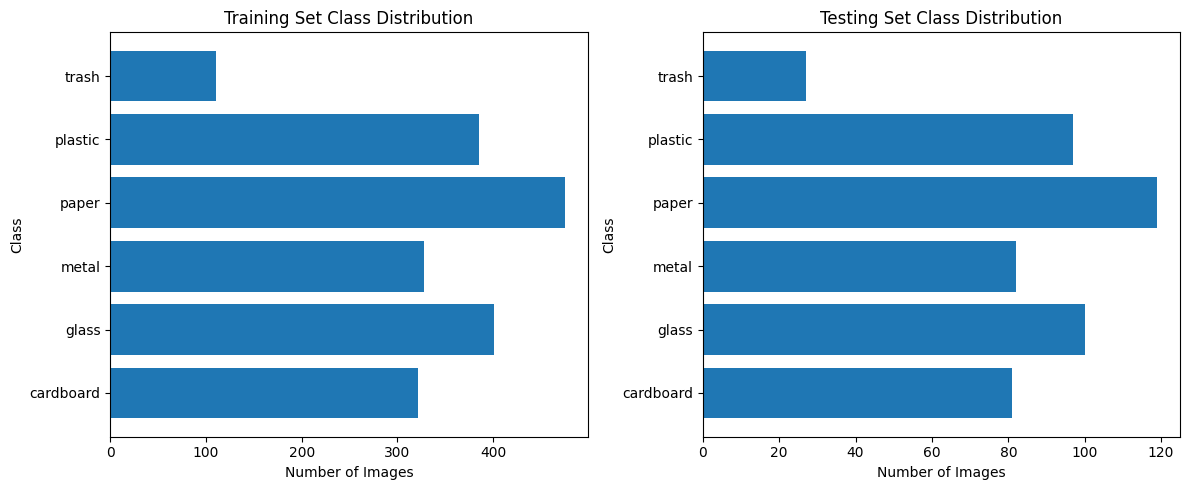

In [13]:
from collections import Counter
import matplotlib.pyplot as plt

# Calculate class distributions
train_counter = Counter([dataset.targets[i] for i in train_idx])
test_counter = Counter([dataset.targets[i] for i in test_idx])

train_labels = list(train_counter.keys())
train_values = list(train_counter.values())

test_labels = list(test_counter.keys())
test_values = list(test_counter.values())

# Plot the distributions with horizontal bars
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
ax[0].barh(train_labels, train_values, tick_label=[classes[i] for i in train_labels])
ax[0].set_title("Training Set Class Distribution")
ax[0].set_ylabel("Class")
ax[0].set_xlabel("Number of Images")

# Testing set distribution
ax[1].barh(test_labels, test_values, tick_label=[classes[i] for i in test_labels])
ax[1].set_title("Testing Set Class Distribution")
ax[1].set_ylabel("Class")
ax[1].set_xlabel("Number of Images")

plt.tight_layout()
plt.show()


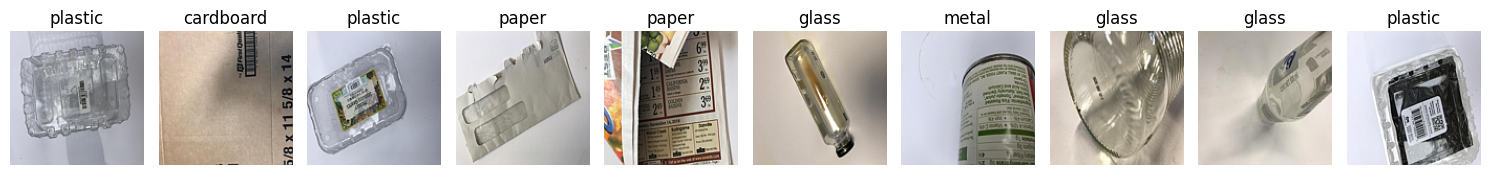

In [17]:
# Function to display images with labels
def imshow_with_labels(images, labels, classes):
    images = images / 2 + 0.5  # Unnormalize
    npimg = images.numpy()
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(npimg[i], (1, 2, 0)))
        ax.set_title(classes[labels[i].item()])  # Convert tensor to index and map to English
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display the first n images with labels
n = 10  # Display fewer images for readability
imshow_with_labels(images[:n], labels[:n], classes)


# Model

In [19]:
from torchvision.models import resnet18, mobilenet_v2, efficientnet_b0
# Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of classes (TrashNet has 6 classes)
num_classes = 6

# Define ResNet-18
resnet18_model = resnet18(pretrained=True)
for param in resnet18_model.parameters():
    param.requires_grad = True  # Unfreeze all layers
# Modify the fully connected (FC) layer for 6 classes
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, num_classes)
resnet18_model.fc.requires_grad = True  # Ensure the final layer is trainable
resnet18_model = resnet18_model.to(device)

# Define MobileNet_v2
mobilenet_v2_model = mobilenet_v2(pretrained=True)
for param in mobilenet_v2_model.features.parameters():
    param.requires_grad = True  # Unfreeze all layers in the features section
# Modify the classifier for 6 classes
mobilenet_v2_model.classifier[1] = nn.Linear(mobilenet_v2_model.last_channel, num_classes)
mobilenet_v2_model.classifier[1].requires_grad = True
mobilenet_v2_model = mobilenet_v2_model.to(device)

# Define EfficientNet_B0
efficientnet_b0_model = efficientnet_b0(pretrained=True)
for param in efficientnet_b0_model.parameters():
    param.requires_grad = True  # Unfreeze all layers
# Modify the classifier for 6 classes
efficientnet_b0_model.classifier[1] = nn.Linear(efficientnet_b0_model.classifier[1].in_features, num_classes)
efficientnet_b0_model.classifier[1].requires_grad = True
efficientnet_b0_model = efficientnet_b0_model.to(device)

# Print a summary of one model (optional)
print(resnet18_model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Before training

ResNet-18 Metrics:
Accuracy: 15.61%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.09      0.16      0.12        81
       glass       0.20      0.26      0.23       100
       metal       0.00      0.00      0.00        82
       paper       0.18      0.34      0.23       119
     plastic       0.00      0.00      0.00        97
       trash       0.00      0.00      0.00        27

    accuracy                           0.16       506
   macro avg       0.08      0.13      0.10       506
weighted avg       0.10      0.16      0.12       506



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


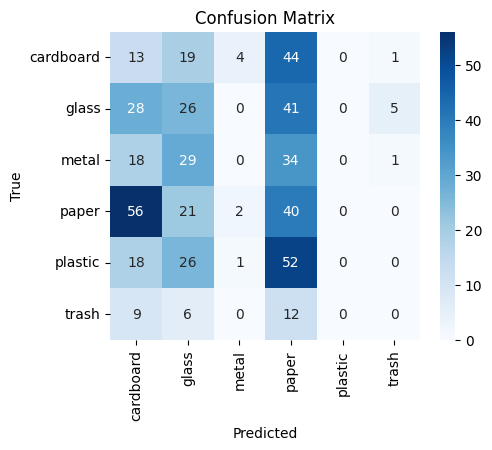


MobileNet_v2 Metrics:
Accuracy: 16.60%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.18      0.30      0.22        81
       glass       0.14      0.23      0.17       100
       metal       0.17      0.09      0.11        82
       paper       0.19      0.07      0.10       119
     plastic       0.18      0.23      0.20        97
       trash       0.00      0.00      0.00        27

    accuracy                           0.17       506
   macro avg       0.14      0.15      0.13       506
weighted avg       0.16      0.17      0.15       506



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


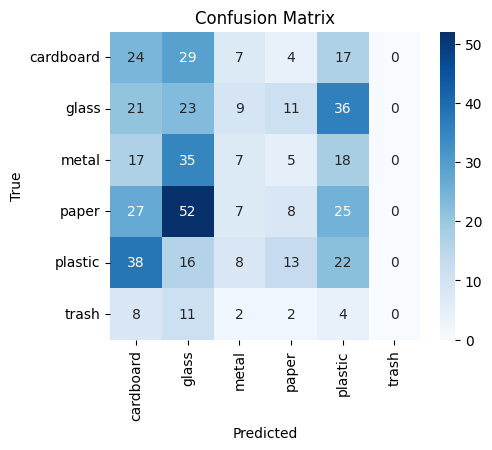


EfficientNet_B0 Metrics:
Accuracy: 17.59%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.27      0.31      0.29        81
       glass       0.23      0.08      0.12       100
       metal       0.18      0.09      0.12        82
       paper       0.24      0.27      0.25       119
     plastic       0.15      0.09      0.11        97
       trash       0.06      0.30      0.09        27

    accuracy                           0.18       506
   macro avg       0.19      0.19      0.16       506
weighted avg       0.20      0.18      0.17       506



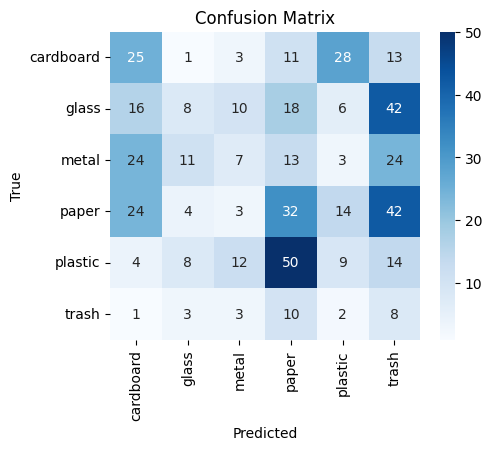

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to calculate detailed metrics
def evaluate_model(model, data_loader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    print(f"Accuracy: {accuracy:.2f}%")

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=classes, digits=2)
    print("Classification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, report, cm

# Evaluate ResNet-18
print("ResNet-18 Metrics:")
resnet18_accuracy_before, resnet18_report_before, resnet18_cm_before = evaluate_model(resnet18_model, test_loader, device, classes)

# Evaluate MobileNet_v2
print("\nMobileNet_v2 Metrics:")
mobilenet_v2_accuracy_before, mobilenet_v2_report_before, mobilenet_v2_cm_before = evaluate_model(mobilenet_v2_model, test_loader, device, classes)

# Evaluate EfficientNet_B0
print("\nEfficientNet_B0 Metrics:")
efficientnet_b0_accuracy_before, efficientnet_b0_report_before, efficientnet_b0_cm_before = evaluate_model(efficientnet_b0_model, test_loader, device, classes)


# Training

In [21]:
import torch.optim as optim
from torch.utils.data import random_split
from collections import Counter
import random
from torchvision.transforms import functional as TF

# ================== Define the Training Function ==================
def train_model(model, train_loader, val_loader=None, criterion=None, optimizer=None, device=None, epochs=20, patience=5):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf') if val_loader else None
    patience_counter = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss = val_loss / len(val_loader)
            val_losses.append(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

    return train_losses, val_losses if val_loader else train_losses

# ================== Split the Training Data ==================
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_idx, val_idx = random_split(range(len(train_set)), [train_size, val_size])

# Create subsets for training and validation
train_subset = torch.utils.data.Subset(train_set, train_idx)
val_subset = torch.utils.data.Subset(train_set, val_idx)

# ================== Class Balancing for Training Subset ==================
augmented_images = []
augmented_labels = []

# Count images per class
class_counts = Counter([train_set.dataset.targets[i] for i in train_idx])
max_class_count = max(class_counts.values())

# Augment underrepresented classes
for class_idx, count in class_counts.items():
    if count < max_class_count:
        diff = max_class_count - count
        print(f"Augmenting class {classes[class_idx]}: {count} -> {max_class_count}")

        # Get all images and their correct labels for this class
        class_images = [train_set.dataset[i] for i in train_idx if train_set.dataset.targets[i] == class_idx]

        # Apply augmentations
        for _ in range(diff):
            img, label = random.choice(class_images)  # Preserve correct label
            augmented_img = TF.rotate(img, angle=random.uniform(-15, 15))
            augmented_img = TF.hflip(augmented_img) if random.random() > 0.5 else augmented_img
            augmented_images.append(augmented_img)
            augmented_labels.append(label)

# Combine original and augmented data for the training subset
train_dataset = [(train_set.dataset[i][0], train_set.dataset.targets[i]) for i in train_idx]
train_dataset.extend(zip(augmented_images, augmented_labels))

# ================== Create DataLoaders ==================
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

# ================== Define Common Training Settings ==================
criterion = torch.nn.CrossEntropyLoss()

# ================== Train ResNet-18 ==================
print("Training ResNet-18...")
resnet18_optimizer = optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9)
resnet18_train_losses, resnet18_val_losses = train_model(
    resnet18_model, train_loader, val_loader, criterion, resnet18_optimizer, device
)

# ================== Train MobileNet_v2 ==================
print("\nTraining MobileNet_v2...")
mobilenet_v2_optimizer = optim.SGD(mobilenet_v2_model.parameters(), lr=0.001, momentum=0.9)
mobilenet_v2_train_losses, mobilenet_v2_val_losses = train_model(
    mobilenet_v2_model, train_loader, val_loader, criterion, mobilenet_v2_optimizer, device
)

# ================== Train EfficientNet_B0 ==================
print("\nTraining EfficientNet_B0...")
efficientnet_b0_optimizer = optim.SGD(efficientnet_b0_model.parameters(), lr=0.001, momentum=0.9)
efficientnet_b0_train_losses, efficientnet_b0_val_losses = train_model(
    efficientnet_b0_model, train_loader, val_loader, criterion, efficientnet_b0_optimizer, device
)


Augmenting class cardboard: 325 -> 470
Augmenting class metal: 327 -> 470
Augmenting class glass: 401 -> 470
Augmenting class plastic: 93 -> 470
Training ResNet-18...
Epoch 1/20, Train Loss: 1.1948, Val Loss: 1.0364
Epoch 2/20, Train Loss: 0.4405, Val Loss: 0.8624
Epoch 3/20, Train Loss: 0.2433, Val Loss: 0.8214
Epoch 4/20, Train Loss: 0.1529, Val Loss: 0.8020
Epoch 5/20, Train Loss: 0.0956, Val Loss: 0.7769
Epoch 6/20, Train Loss: 0.0665, Val Loss: 0.7730
Epoch 7/20, Train Loss: 0.0544, Val Loss: 0.8008
Epoch 8/20, Train Loss: 0.0394, Val Loss: 0.7753
Epoch 9/20, Train Loss: 0.0325, Val Loss: 0.7792
Epoch 10/20, Train Loss: 0.0256, Val Loss: 0.8128
Early stopping at epoch 11

Training MobileNet_v2...
Epoch 1/20, Train Loss: 1.0910, Val Loss: 0.9518
Epoch 2/20, Train Loss: 0.3730, Val Loss: 0.7320
Epoch 3/20, Train Loss: 0.2075, Val Loss: 0.7212
Epoch 4/20, Train Loss: 0.1176, Val Loss: 0.6897
Epoch 5/20, Train Loss: 0.0714, Val Loss: 0.6871
Epoch 6/20, Train Loss: 0.0532, Val Loss: 0.

# After training

ResNet-18 Metrics:
Accuracy: 86.56%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.96      0.98      0.97        81
       glass       0.78      0.98      0.87       100
       metal       0.88      1.00      0.94        82
       paper       0.83      0.98      0.90       119
     plastic       0.97      0.64      0.77        97
       trash       0.00      0.00      0.00        27

    accuracy                           0.87       506
   macro avg       0.74      0.76      0.74       506
weighted avg       0.83      0.87      0.84       506



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


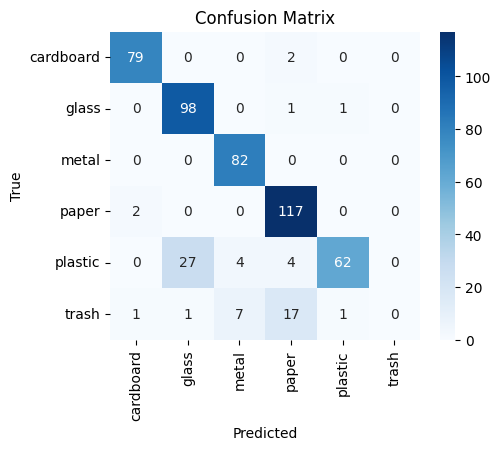


MobileNet_v2 Metrics:
Accuracy: 87.15%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.95      0.98      0.96        81
       glass       0.82      0.97      0.89       100
       metal       0.87      0.96      0.91        82
       paper       0.82      0.98      0.89       119
     plastic       0.97      0.71      0.82        97
       trash       0.00      0.00      0.00        27

    accuracy                           0.87       506
   macro avg       0.74      0.77      0.75       506
weighted avg       0.83      0.87      0.85       506



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


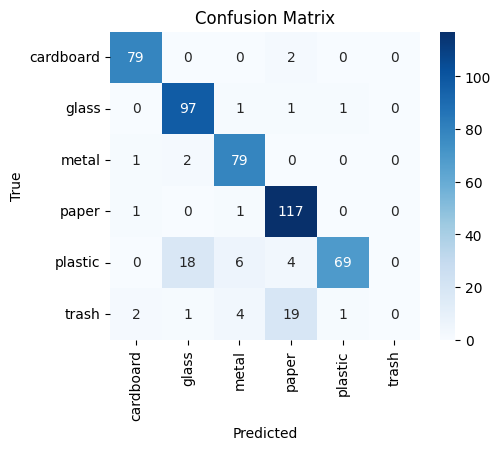


EfficientNet_B0 Metrics:
Accuracy: 88.14%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.96      1.00      0.98        81
       glass       0.83      0.98      0.90       100
       metal       0.87      0.99      0.93        82
       paper       0.87      0.99      0.93       119
     plastic       0.91      0.70      0.79        97
       trash       0.00      0.00      0.00        27

    accuracy                           0.88       506
   macro avg       0.74      0.78      0.75       506
weighted avg       0.84      0.88      0.85       506



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


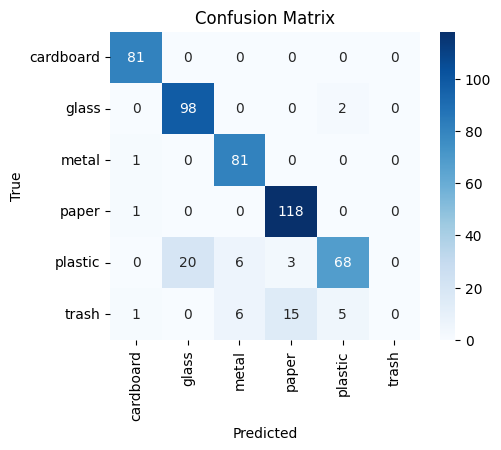

In [22]:
# Evaluate ResNet-18
print("ResNet-18 Metrics:")
resnet18_accuracy_after, resnet18_report_after, resnet18_cm_after = evaluate_model(resnet18_model, test_loader, device, classes)

# Evaluate MobileNet_v2
print("\nMobileNet_v2 Metrics:")
mobilenet_v2_accuracy_after, mobilenet_v2_report_after, mobilenet_v2_cm_after = evaluate_model(mobilenet_v2_model, test_loader, device, classes)

# Evaluate EfficientNet_B0
print("\nEfficientNet_B0 Metrics:")
efficientnet_b0_accuracy_after, efficientnet_b0_report_after, efficientnet_b0_cm_after = evaluate_model(efficientnet_b0_model, test_loader, device, classes)


In [23]:
# Store results for comparison
results = {
    "ResNet-18": {
        "Before Training": {"Accuracy": resnet18_accuracy_before},
        "After Training": {"Accuracy": resnet18_accuracy_after},
    },
    "MobileNet_v2": {
        "Before Training": {"Accuracy": mobilenet_v2_accuracy_before},
        "After Training": {"Accuracy": mobilenet_v2_accuracy_after},
    },
    "EfficientNet_B0": {
        "Before Training": {"Accuracy": efficientnet_b0_accuracy_before},
        "After Training": {"Accuracy": efficientnet_b0_accuracy_after},
    },
}

# Print the summarized results
for model, accuracy in results.items():
    print(f"\n{model} Results:")
    print(f"  Before Training Accuracy: {accuracy['Before Training']['Accuracy']:.2f}%")
    print(f"  After Training Accuracy: {accuracy['After Training']['Accuracy']:.2f}%")



ResNet-18 Results:
  Before Training Accuracy: 15.61%
  After Training Accuracy: 86.56%

MobileNet_v2 Results:
  Before Training Accuracy: 16.60%
  After Training Accuracy: 87.15%

EfficientNet_B0 Results:
  Before Training Accuracy: 17.59%
  After Training Accuracy: 88.14%


ResNet-18 Misclassifications:


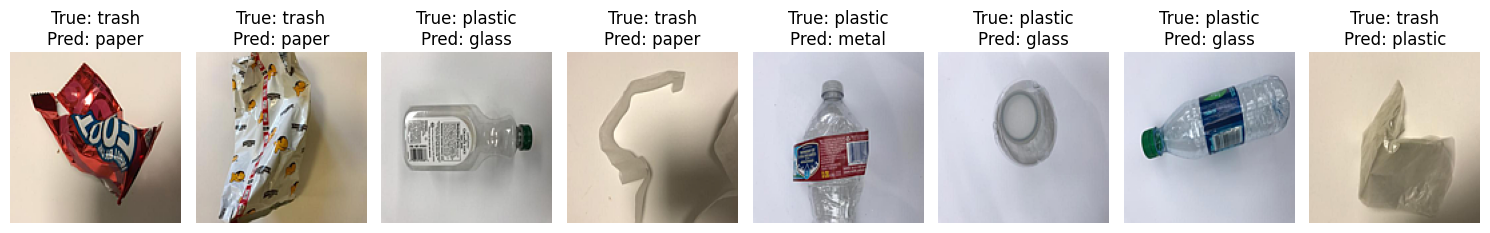

In [25]:
def visualize_misclassifications(model, data_loader, device, classes, num_images=8):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))
                    if len(misclassified) >= num_images:
                        break
            if len(misclassified) >= num_images:
                break

    # Handle case with fewer misclassifications
    num_to_plot = min(len(misclassified), num_images)

    # Plot misclassified images
    fig, axes = plt.subplots(1, num_to_plot, figsize=(15, 5))
    if num_to_plot == 1:
        axes = [axes]  # Handle single subplot case
    for ax, (img, true_label, pred_label) in zip(axes, misclassified):
        img = img / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize for ResNet-18
print("ResNet-18 Misclassifications:")
visualize_misclassifications(resnet18_model, test_loader, device, classes, num_images=8)


In [ ]:
import os
import json
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a symbolic link for easier access
!ln -s "/content/drive/MyDrive/Colab Notebooks/Computer Vision/Experimentation_3" /content/Experimentation_3
print("Symbolic link created: /content/Experimentation_3")

# Define the path to the Results folder
folder_path = '/content/Experimentation_3/Results'

# Create the Results folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)
print(f"Folder created (or already exists) at: {folder_path}")

# Define the path for the JSON file for Version 1
json_file_path = os.path.join(folder_path, "model_results_v1.json")

# Save the results as Version 1
try:
    with open(json_file_path, "w") as f:
        json.dump(results, f, indent=4)
    print(f"Version 1 Results saved to: {json_file_path}")
except NameError:
    print("Error: The 'results' dictionary is not defined. Ensure you have results from your experiments.")
